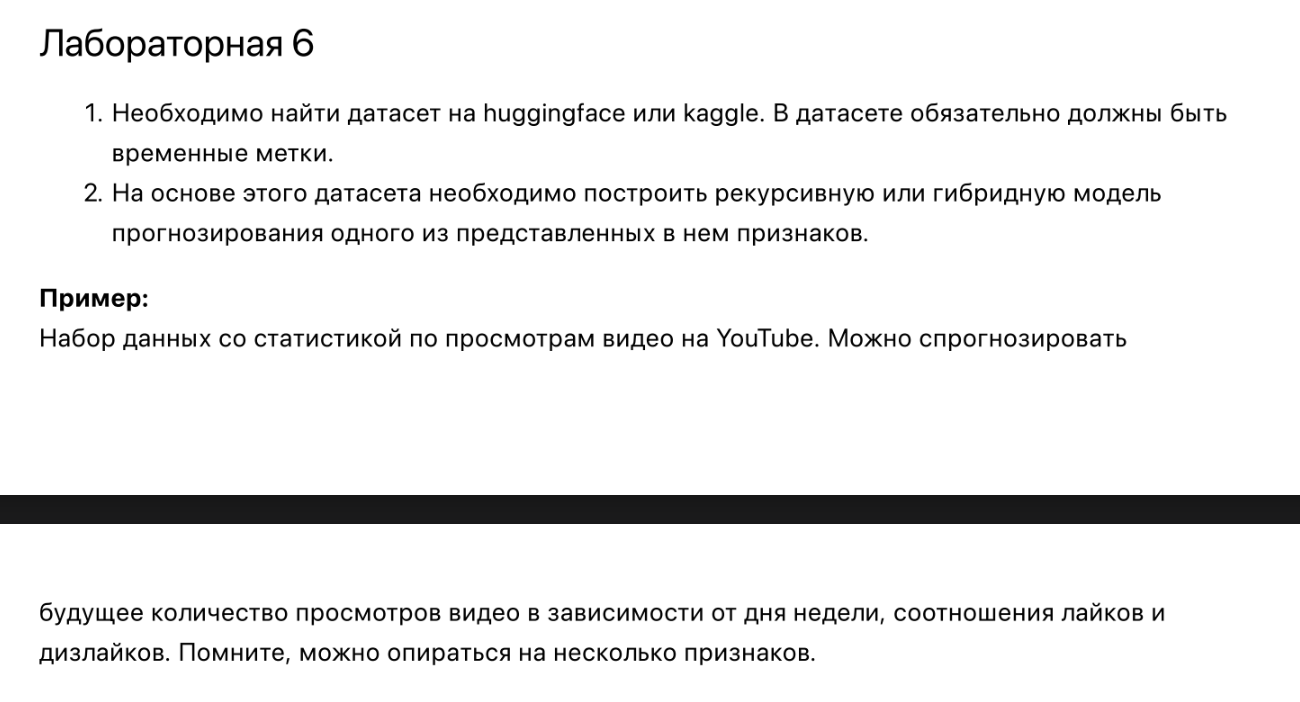

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [32]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [33]:
SEQ_LENGTH = 14
INPUT_SIZE = 3
HIDDEN_SIZE = 64
NUM_LAYERS = 1
OUTPUT_SIZE = 1
NUM_EPOCHS = 500
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LR = 0.01

In [34]:
DEVICE

'cuda'

In [35]:
df = pd.read_csv("../data/football_results.csv")

df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)

le_home = LabelEncoder()
le_away = LabelEncoder()
le_country = LabelEncoder()

df["home_team_encoded"] = le_home.fit_transform(df["home_team"])
df["away_team_encoded"] = le_away.fit_transform(df["away_team"])
df["country_encoded"] = le_country.fit_transform(df["country"])

features = [
    "home_team_encoded",
    "away_team_encoded",
    # "country_encoded",
    "home_score",
    # "away_score",
]
dataset = df[features].values
dataset = dataset.astype("float32")

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [36]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i : (i + seq_length)]
        y = data[i + seq_length][0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [37]:
X, y = create_sequences(scaled_data, SEQ_LENGTH)

In [38]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

X_train_t = torch.Tensor(X_train).to(DEVICE)
y_train_t = torch.Tensor(y_train).to(DEVICE)
X_test_t = torch.Tensor(X_test).to(DEVICE)
y_test_t = torch.Tensor(y_test).to(DEVICE)

In [39]:
class LSTMModel(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        num_layers,
        output_size,
    ):
        super(LSTMModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
        ).to(DEVICE)
        self.fc = nn.Linear(hidden_size, output_size).to(DEVICE)

    def forward(self, x):
        h0 = torch.zeros(
            self.num_layers,
            x.size(0),
            self.hidden_size,
        ).to(DEVICE)

        c0 = torch.zeros(
            self.num_layers,
            x.size(0),
            self.hidden_size,
        ).to(DEVICE)

        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)

        return out

In [40]:
model = LSTMModel(
    INPUT_SIZE,
    HIDDEN_SIZE,
    NUM_LAYERS,
    OUTPUT_SIZE,
).to(DEVICE)

criterion = nn.MSELoss().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

Epoch: 0, Loss: 0.30231
Epoch: 100, Loss: 0.07163
Epoch: 200, Loss: 0.06993
Epoch: 300, Loss: 0.06707
Epoch: 400, Loss: 0.06598


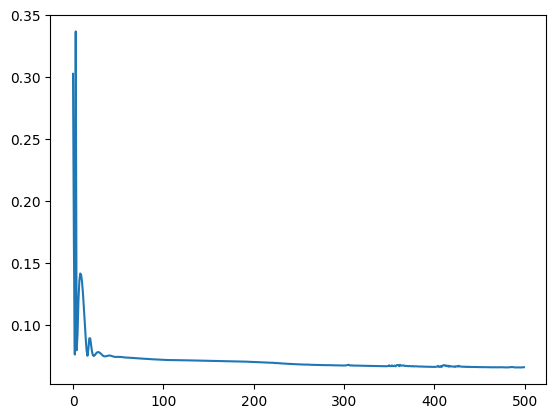

In [41]:
losses = []

for epoch in range(NUM_EPOCHS):
    outputs = model(X_train_t)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_t.unsqueeze(1))

    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item():.5f}")

plt.plot(losses)

In [42]:
model.eval()

with torch.no_grad():
    train_predict = model(X_train_t).cpu().data.numpy()
    test_predict = model(X_test_t).cpu().data.numpy()


def inverse_transform(prediction, scaler):
    dummy = np.zeros((len(prediction), INPUT_SIZE))
    dummy[:, 0] = prediction[:, 0]
    return scaler.inverse_transform(dummy)[:, 0]

In [43]:
y_train_inv = inverse_transform(y_train_t.unsqueeze(1).cpu().numpy(), scaler)
y_test_inv = inverse_transform(y_test_t.unsqueeze(1).cpu().numpy(), scaler)
train_predict_inv = inverse_transform(train_predict, scaler)
test_predict_inv = inverse_transform(test_predict, scaler)

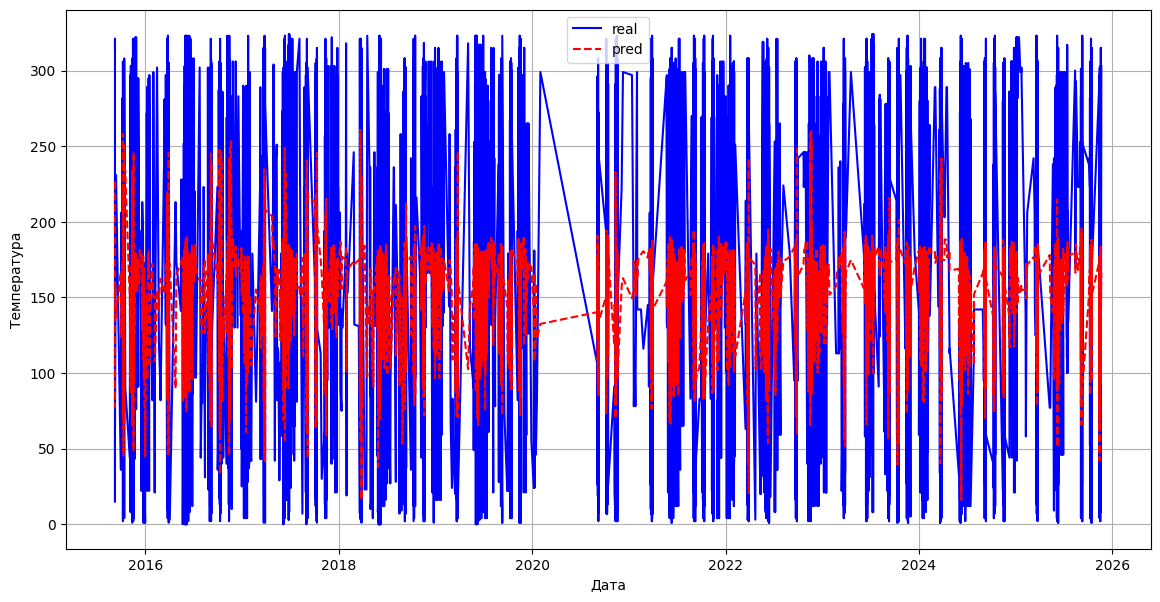

In [44]:
plt.figure(figsize=(14, 7))

train_range = df.index[SEQ_LENGTH : train_size + SEQ_LENGTH]
test_range = df.index[train_size + SEQ_LENGTH :]

plt.plot(test_range, y_test_inv, label="real", color="blue")
plt.plot(
    test_range,
    test_predict_inv,
    label="pred",
    color="red",
    linestyle="--",
)

plt.xlabel("Дата")
plt.ylabel("Температура")
plt.legend()
plt.grid(True)
plt.show()